In [2]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import re
import numpy as np
from bs4 import BeautifulSoup
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_csv('/content/drive/MyDrive/pse_isr_reddit_comments.csv')
df

,comment_id,score,self_text,subreddit,created_time
0,k70vrzb,1,Lol what kind of busted translator device you ...,IsraelPalestine,2023-10-29 23:59:03+00:00
1,k70vk4r,1,Translation:\n\nAmen. Kill jews and continue g...,IsraelPalestine,2023-10-29 23:57:29+00:00
2,k70vhew,1,Friendly fact reminder: Israel has been steali...,IsraelPalestine,2023-10-29 23:56:58+00:00
3,k70ve4h,1,"Well, i would never support Hamas, but there a...",IsraelPalestine,2023-10-29 23:56:18+00:00
4,k70vay1,1,/u/TickeMeTendie. This is an automatic notice:...,IsraelPalestine,2023-10-29 23:55:42+00:00
...,...,...,...,...,...
436720,k3sdwfc,42,US. This is bullshit,Palestine,2023-10-06 23:50:11+00:00
436721,k3sdixt,1,I am in the United States and it has the dotte...,Palestine,2023-10-06 23:47:23+00:00
436722,k3sccp2,54,In which country are you?\nSometimes maps adap...,Palestine,2023-10-06 23:38:26+00:00
436723,k3ritvj,116,You can't give up on something you only preten...,worldnews,2023-10-06 20:16:05+00:00


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 436725 entries, 0 to 436724
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   comment_id    436725 non-null  object
 1   score         436725 non-null  int64 
 2   self_text     436725 non-null  object
 3   subreddit     436725 non-null  object
 4   created_time  436725 non-null  object
dtypes: int64(1), object(4)
memory usage: 16.7+ MB


In [6]:
df['self_text'] = df['self_text'] + ' and the confidence is ' + (df['score'] * 100).astype(str) + ' percent.'

In [7]:
for i in range(10):
    print(df.self_text[i])

Lol what kind of busted translator device you got. Does it speak only hasbara? and the confidence is 100 percent.
Translation:

Amen. Kill jews and continue gazan oppression! and the confidence is 100 percent.
Friendly fact reminder: Israel has been stealing Palestines land, bombing their civilians, controlling their access to water/food and kidnapping Palestinian civilians for over 50 years. Israel has  been committing genocide on Palestine but somehow people like you like to place the blame on Palestine. If you think Hamas is bad, I have some bad news about the IDF for you. and the confidence is 100 percent.
Well, i would never support Hamas, but there actions Israel could do that would make me stop supporting it: State orginized killing of Israeli or west bank Arabs or use of Atomic weaponary. and the confidence is 100 percent.
/u/TickeMeTendie. This is an automatic notice: 
'Nazis' Casual comments and analogies are inflammatory and therefor not allowed.  
We allow for exemptions fo

In [8]:
# Remove "@user"
df['clean_text'] = df.self_text.str.replace('@user', '')

# Replace non-alphanumeric characters with spaces
df['clean_text'] = df['clean_text'].str.replace("[^\w\s]", " ", regex=True)

# Remove "<br />"
df['clean_text'] = df['clean_text'].str.replace("<br />", " ")

# Remove mentions (@mentions)
df['clean_text'] = df['clean_text'].str.replace("@[A-Za-z0-9]+", " ", regex=True)

# Remove URLs
df['clean_text'] = df['clean_text'].str.replace("https?://[A-Za-z0-9./]+", " ", regex=True)

# Remove excess spaces
df['clean_text'] = df['clean_text'].str.replace(" +", " ", regex=True)

# Remove specific characters
df['clean_text'] = df['clean_text'].str.replace("[<>/;&]", " ", regex=True)

#Remove tabs
df['clean_text'] = df['clean_text'].str.replace("\n", " ")

In [9]:
df.head(5)

,comment_id,score,self_text,subreddit,created_time,clean_text
0,k70vrzb,1,Lol what kind of busted translator device you ...,IsraelPalestine,2023-10-29 23:59:03+00:00,Lol what kind of busted translator device you ...
1,k70vk4r,1,Translation:\n\nAmen. Kill jews and continue g...,IsraelPalestine,2023-10-29 23:57:29+00:00,Translation Amen Kill jews and continue gaza...
2,k70vhew,1,Friendly fact reminder: Israel has been steali...,IsraelPalestine,2023-10-29 23:56:58+00:00,Friendly fact reminder Israel has been stealin...
3,k70ve4h,1,"Well, i would never support Hamas, but there a...",IsraelPalestine,2023-10-29 23:56:18+00:00,Well i would never support Hamas but there act...
4,k70vay1,1,/u/TickeMeTendie. This is an automatic notice:...,IsraelPalestine,2023-10-29 23:55:42+00:00,u TickeMeTendie This is an automatic notice ...


In [10]:
#tokenization
df['clean_text'] = df['clean_text'].apply(lambda x: str(x) if type(x) != str else x)
df['clean_text'] = df['clean_text'].apply(lambda x: x.split())
df.head()

,comment_id,score,self_text,subreddit,created_time,clean_text
0,k70vrzb,1,Lol what kind of busted translator device you ...,IsraelPalestine,2023-10-29 23:59:03+00:00,"[Lol, what, kind, of, busted, translator, devi..."
1,k70vk4r,1,Translation:\n\nAmen. Kill jews and continue g...,IsraelPalestine,2023-10-29 23:57:29+00:00,"[Translation, Amen, Kill, jews, and, continue,..."
2,k70vhew,1,Friendly fact reminder: Israel has been steali...,IsraelPalestine,2023-10-29 23:56:58+00:00,"[Friendly, fact, reminder, Israel, has, been, ..."
3,k70ve4h,1,"Well, i would never support Hamas, but there a...",IsraelPalestine,2023-10-29 23:56:18+00:00,"[Well, i, would, never, support, Hamas, but, t..."
4,k70vay1,1,/u/TickeMeTendie. This is an automatic notice:...,IsraelPalestine,2023-10-29 23:55:42+00:00,"[u, TickeMeTendie, This, is, an, automatic, no..."


In [11]:
#stemmer
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")
df['clean_text']= df['clean_text'].apply(lambda x: [stemmer.stem(i) for i in x])
df.head()

,comment_id,score,self_text,subreddit,created_time,clean_text
0,k70vrzb,1,Lol what kind of busted translator device you ...,IsraelPalestine,2023-10-29 23:59:03+00:00,"[lol, what, kind, of, bust, translat, devic, y..."
1,k70vk4r,1,Translation:\n\nAmen. Kill jews and continue g...,IsraelPalestine,2023-10-29 23:57:29+00:00,"[translat, amen, kill, jew, and, continu, gaza..."
2,k70vhew,1,Friendly fact reminder: Israel has been steali...,IsraelPalestine,2023-10-29 23:56:58+00:00,"[friend, fact, remind, israel, has, been, stea..."
3,k70ve4h,1,"Well, i would never support Hamas, but there a...",IsraelPalestine,2023-10-29 23:56:18+00:00,"[well, i, would, never, support, hama, but, th..."
4,k70vay1,1,/u/TickeMeTendie. This is an automatic notice:...,IsraelPalestine,2023-10-29 23:55:42+00:00,"[u, tickemetendi, this, is, an, automat, notic..."


In [12]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [13]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
stopwords = nltk.corpus.stopwords.words('english')

In [14]:
newStopWords = ['u','go','got','via','or','ur','us','in','i','let','the','to','is','amp','make','one','day','days','get']
stopwords.extend(newStopWords)

In [15]:
import string
def process(text):
    # Check characters to see if they are in punctuation
    nopunc = set(char for char in list(text) if char not in string.punctuation)
    # Join the characters to form the string.
    nopunc = " ".join(nopunc)
    # remove any stopwords if present
    return [word for word in nopunc.lower().split() if word.lower() not in stopwords]

In [16]:
df['clean_text'] = df['clean_text'].apply(process)
df.head()

,comment_id,score,self_text,subreddit,created_time,clean_text
0,k70vrzb,1,Lol what kind of busted translator device you ...,IsraelPalestine,2023-10-29 23:59:03+00:00,"[onli, 100, lol, bust, kind, speak, doe, confi..."
1,k70vk4r,1,Translation:\n\nAmen. Kill jews and continue g...,IsraelPalestine,2023-10-29 23:57:29+00:00,"[kill, gazan, 100, percent, jew, continu, conf..."
2,k70vhew,1,Friendly fact reminder: Israel has been steali...,IsraelPalestine,2023-10-29 23:56:58+00:00,"[water, bad, fact, kidnap, genocid, steal, foo..."
3,k70ve4h,1,"Well, i would never support Hamas, but there a...",IsraelPalestine,2023-10-29 23:56:18+00:00,"[west, would, orgin, kill, atom, 100, well, ha..."
4,k70vay1,1,/u/TickeMeTendie. This is an automatic notice:...,IsraelPalestine,2023-10-29 23:55:42+00:00,"[automat, detect, notic, pleas, therefor, word..."


In [17]:
for i in range(10):
    print(df.clean_text[i])

['onli', '100', 'lol', 'bust', 'kind', 'speak', 'doe', 'confid', 'translat', 'percent', 'devic', 'hasbara']
['kill', 'gazan', '100', 'percent', 'jew', 'continu', 'confid', 'translat', 'oppress', 'amen']
['water', 'bad', 'fact', 'kidnap', 'genocid', 'steal', 'food', '100', 'hama', 'news', 'bomb', 'year', 'think', 'idf', 'peopl', 'place', 'palestin', 'somehow', 'commit', 'like', 'confid', 'friend', 'civilian', 'land', 'control', 'palestinian', 'blame', 'access', '50', 'percent', 'remind', 'israel']
['west', 'would', 'orgin', 'kill', 'atom', '100', 'well', 'hama', 'state', 'arab', 'weaponari', 'never', 'bank', 'confid', 'support', 'isra', 'israel', 'percent', 'use', 'action', 'could', 'stop']
['automat', 'detect', 'notic', 'pleas', 'therefor', 'word', '100', '6', 'confirm', 'cannot', 'www', 'concern', 'meaning', 'unaccept', 'complianc', 'percent', 'reddit', 'https', 'tickemetendi', 'allow', 'simpl', 'moment', 'subreddit', 'take', 'r', 'perform', 'compos', 'israelpalestin', 'see', 'usag', 

VADER

In [18]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [19]:
from nltk.sentiment import SentimentIntensityAnalyzer
import pandas as pd

# Assuming df['clean_text'] is a list of strings
df['clean_text'] = df['clean_text'].apply(lambda x: ' '.join(map(str, x)) if isinstance(x, list) else x)

# Initialize the Sentiment Intensity Analyzer
analyzer = SentimentIntensityAnalyzer()

# Declare variables for scores
scores = {
    "Compound": [],
    "Positive": [],
    "Negative": [],
    "Neutral": []
}

# Generate sentiment scores for Reddit comments
for comment in df['clean_text']:
    compound = analyzer.polarity_scores(comment)["compound"]
    pos = analyzer.polarity_scores(comment)["pos"]
    neu = analyzer.polarity_scores(comment)["neu"]
    neg = analyzer.polarity_scores(comment)["neg"]

    scores["Compound"].append(compound)
    scores["Positive"].append(pos)
    scores["Negative"].append(neg)
    scores["Neutral"].append(neu)

# Create a new DataFrame for sentiment scores
sentiments_score = pd.DataFrame(scores)

# Join the sentiment scores DataFrame with the original DataFrame
df = pd.concat([df, sentiments_score], axis=1)

In [20]:
df.head()

,comment_id,score,self_text,subreddit,created_time,clean_text,Compound,Positive,Negative,Neutral
0,k70vrzb,1,Lol what kind of busted translator device you ...,IsraelPalestine,2023-10-29 23:59:03+00:00,onli 100 lol bust kind speak doe confid transl...,0.7351,0.383,0.000,0.617
1,k70vk4r,1,Translation:\n\nAmen. Kill jews and continue g...,IsraelPalestine,2023-10-29 23:57:29+00:00,kill gazan 100 percent jew continu confid tran...,-0.6908,0.000,0.343,0.657
2,k70vhew,1,Friendly fact reminder: Israel has been steali...,IsraelPalestine,2023-10-29 23:56:58+00:00,water bad fact kidnap genocid steal food 100 h...,-0.6597,0.175,0.272,0.553
3,k70ve4h,1,"Well, i would never support Hamas, but there a...",IsraelPalestine,2023-10-29 23:56:18+00:00,west would orgin kill atom 100 well hama state...,-0.7940,0.072,0.313,0.615
4,k70vay1,1,/u/TickeMeTendie. This is an automatic notice:...,IsraelPalestine,2023-10-29 23:55:42+00:00,automat detect notic pleas therefor word 100 6...,0.6908,0.121,0.000,0.879


In [21]:
# Define conditions for sentiment categories based on 'Compound' scores
# If Compound score is <= -0.5, classify as 'Negative'
# If Compound score is > -0.5 and < 0.5, classify as 'Neutral'
# If Compound score is >= 0.5, classify as 'Positive'
conditions = [
    (df['Compound'] <= -0.5),
    (df['Compound'] > -0.5) & (df['Compound'] < 0.5),
    (df['Compound'] > 0.5)
]

# Define corresponding values for each condition
values = ['Negative', 'Neutral', 'Positive']

# Create a new column 'Category' using np.select to assign values based on the conditions
df['Category'] = np.select(conditions, values)

df.head()

,comment_id,score,self_text,subreddit,created_time,clean_text,Compound,Positive,Negative,Neutral,Category
0,k70vrzb,1,Lol what kind of busted translator device you ...,IsraelPalestine,2023-10-29 23:59:03+00:00,onli 100 lol bust kind speak doe confid transl...,0.7351,0.383,0.000,0.617,Positive
1,k70vk4r,1,Translation:\n\nAmen. Kill jews and continue g...,IsraelPalestine,2023-10-29 23:57:29+00:00,kill gazan 100 percent jew continu confid tran...,-0.6908,0.000,0.343,0.657,Negative
2,k70vhew,1,Friendly fact reminder: Israel has been steali...,IsraelPalestine,2023-10-29 23:56:58+00:00,water bad fact kidnap genocid steal food 100 h...,-0.6597,0.175,0.272,0.553,Negative
3,k70ve4h,1,"Well, i would never support Hamas, but there a...",IsraelPalestine,2023-10-29 23:56:18+00:00,west would orgin kill atom 100 well hama state...,-0.7940,0.072,0.313,0.615,Negative
4,k70vay1,1,/u/TickeMeTendie. This is an automatic notice:...,IsraelPalestine,2023-10-29 23:55:42+00:00,automat detect notic pleas therefor word 100 6...,0.6908,0.121,0.000,0.879,Positive


In [22]:
# Group the DataFrame by 'Category' and count the occurrences of each category
category_counts = df.groupby(['Category'])['Category'].count()

# Create a DataFrame with counts and rename the column to 'Counts'
counts_df = pd.DataFrame(category_counts).rename(columns={"Category": "Counts"})

# Calculate the percentage for each category and add it as a new column 'Percentage'
counts_df['Percentage'] = (counts_df['Counts'] / counts_df['Counts'].sum()) * 100

counts_df = counts_df.drop(index='0')

# Print or return the summary DataFrame
print(counts_df)

          Counts  Percentage
Category                    
Negative  120341   27.555327
Neutral   265172   60.718301
Positive   51208   11.725457


In [23]:
import plotly.express as px

# Create a Pie Chart using Plotly
fig = px.pie(counts_df, values='Counts', names=counts_df.index,
             labels={'Category': 'Sentiment Category', 'Counts': 'Count'},
             title='Distribution of Sentiment Categories in Comments',
             hole=0.3,
             color_discrete_sequence=px.colors.qualitative.Set1)

# Set the background color of the Pie Chart to dark grey
fig.update_layout(paper_bgcolor='darkgrey')


# Show the Plotly Pie Chart
fig.show()

<ipython-input-24-9ebc3156a2cd>:10: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:2496: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


<ipython-input-24-9ebc3156a2cd>:10: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new 

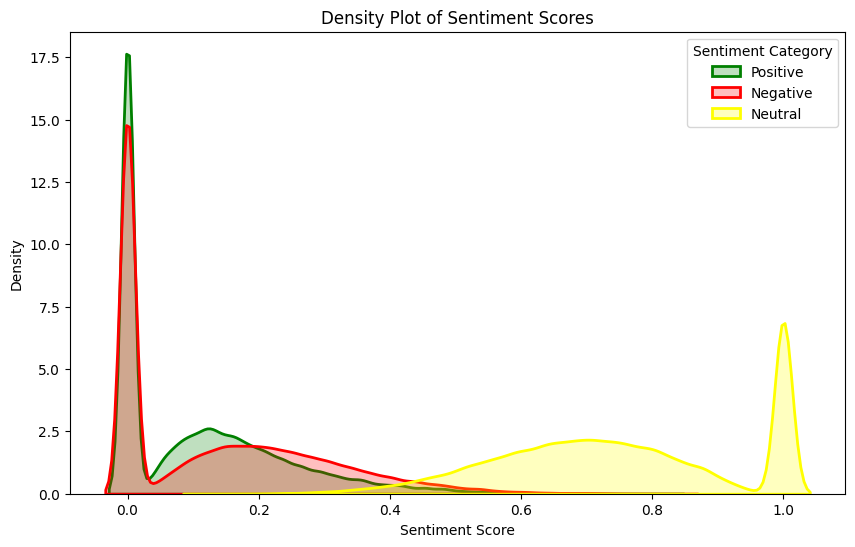

In [24]:
# Define the sentiment categories and corresponding colors
sentiment_categories = ["Positive", "Negative", "Neutral"]
colors = ['green', 'red', 'yellow']

# Set up the plot
plt.figure(figsize=(10, 6))

# Iterate over sentiment categories and plot KDE
for category, color in zip(sentiment_categories, colors):
    sns.distplot(df[category], hist=False, kde=True,
                 bins=int(180/5), color=color,
                 hist_kws={'edgecolor': 'black'},
                 kde_kws={'shade': True, 'linewidth': 2}, label=category)

# Set plot labels and legend
plt.xlabel('Sentiment Score')
plt.ylabel('Density')
plt.title('Density Plot of Sentiment Scores')
plt.legend(title='Sentiment Category')

# Show the plot
plt.show()

<ipython-input-25-e5bd70c8c738>:1: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:2496: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.




<Axes: xlabel='Compound', ylabel='Density'>

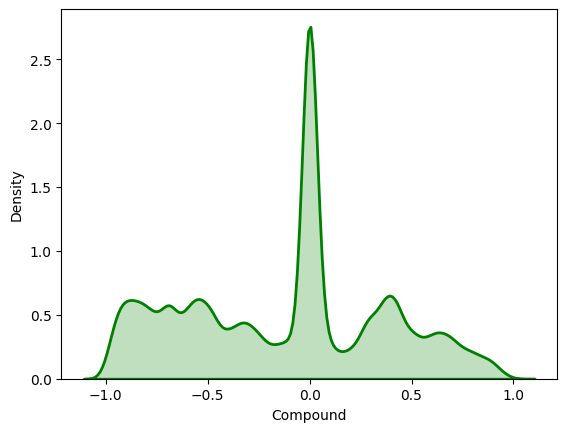

In [25]:
sns.distplot(df["Compound"], hist=False, kde=True,
             bins=int(180/5), color = 'green',
             hist_kws={'edgecolor':'black'},
             kde_kws={'shade': True,'linewidth': 2})

In [26]:
# Calculate the average sentiment scores for each subreddit
subreddit_sentiment = df.groupby('subreddit')[['Positive', 'Negative']].mean()

# Calculate the difference between positive and negative sentiment scores
subreddit_sentiment['Bias'] = subreddit_sentiment['Positive'] - subreddit_sentiment['Negative']

# Determine the direction of bias: Positive, Negative, or Neutral
def determine_bias_direction(bias):
    if bias > 0.01:  # You can adjust this threshold based on your dataset
        return 'Positive'
    elif bias < -0.01:  # You can adjust this threshold based on your dataset
        return 'Negative'
    else:
        return 'Neutral'

subreddit_sentiment['Bias Direction'] = subreddit_sentiment['Bias'].apply(determine_bias_direction)

# Sort subreddits based on bias in descending order
most_biased_subreddits = subreddit_sentiment.sort_values(by='Bias', ascending=False)

# Print or view the most biased subreddits with bias direction
print(most_biased_subreddits)

                       Positive  Negative      Bias Bias Direction
subreddit                                                         
AbruptChaos            0.111624  0.102219  0.009405        Neutral
NonCredibleDefense     0.101923  0.109842 -0.007918        Neutral
Palestine              0.117285  0.134994 -0.017709       Negative
CrazyFuckingVideos     0.104525  0.124049 -0.019525       Negative
AskMiddleEast          0.112184  0.134767 -0.022583       Negative
IsraelPalestine        0.112101  0.140017 -0.027917       Negative
worldnews              0.109190  0.139278 -0.030088       Negative
CombatFootage          0.103492  0.140781 -0.037289       Negative
TerrifyingAsFuck       0.108643  0.146397 -0.037754       Negative
ActualPublicFreakouts  0.107366  0.152929 -0.045563       Negative
worldnewsvideo         0.105320  0.150937 -0.045618       Negative
PublicFreakout         0.103473  0.150577 -0.047105       Negative
IsrealPalestineWar_23  0.111507  0.170819 -0.059312       Nega

In [27]:
df.shape

(436725, 11)

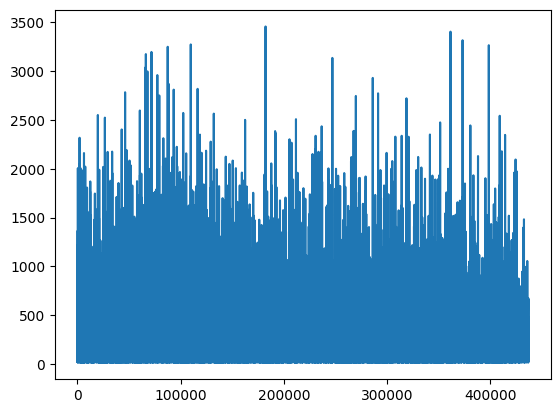

In [28]:
# Plotting word lenghts of comments
word_length = [len(x) for x in df['clean_text']]
plt.plot(word_length)

In [29]:
# Converting sentences to string
df['clean_text'] = df['clean_text'].astype(str)

In [30]:
# Assuming df is your DataFrame
df = df[df['Category'] != '0']

In [31]:
# Types of sentiments
df['Category'].value_counts()

Neutral     265172
Negative    120341
Positive     51208
Name: Category, dtype: int64

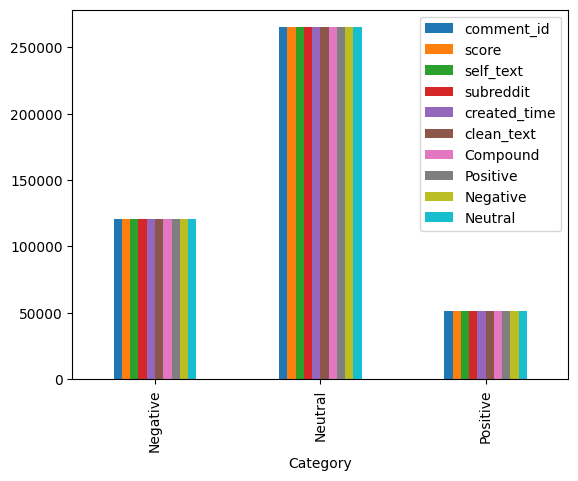

In [32]:
# Plotting sentiment value counts
df.groupby('Category').count().plot(kind='bar')
plt.show()

In [33]:
df = df[['clean_text', 'Category']]
df

,clean_text,Category
0,onli 100 lol bust kind speak doe confid transl...,Positive
1,kill gazan 100 percent jew continu confid tran...,Negative
2,water bad fact kidnap genocid steal food 100 h...,Negative
3,west would orgin kill atom 100 well hama state...,Negative
4,automat detect notic pleas therefor word 100 6...,Positive
...,...,...
436720,percent bullshit confid 4200,Negative
436721,unit west 100 state doe strip dot palestin ban...,Neutral
436722,map frontier matter sometim adapt dot confid f...,Neutral
436723,onli 11600 someth give confid support percent ...,Neutral


In [34]:
df.shape

(436721, 2)

In [35]:
df['Category'].value_counts()

Neutral     265172
Negative    120341
Positive     51208
Name: Category, dtype: int64

Spitting Our Dataset into Training And Testing Dataset ( For Multiclass Classification)

In [36]:
from sklearn.model_selection import train_test_split

train,test = train_test_split(df,test_size = 0.2,random_state=0,stratify = df.Category.values) #stratification means that the train_test_split method returns training and test subsets that have the same proportions of class labels as the input dataset.
print("train shape : ", train.shape)
print("test shape : ", test.shape)

train shape :  (349376, 2)
test shape :  (87345, 2)


In [37]:
!pip install imblearn

Spitting Our Balanced Dataset into Training And Testing Dataset ( For Multiclass Classification)

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from imblearn.over_sampling import SMOTE

# Assuming 'df' is your DataFrame and 'clean_text' is the column containing text data
X_text = df['clean_text']
y = df['Category']

# Splitting the data into training and testing sets
X_train_text, X_test_text, y_train, y_test = train_test_split(X_text, y, test_size=0.2, random_state=0, stratify=y)

# Vectorizing text data
vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train_text)
X_test_vectorized = vectorizer.transform(X_test_text)

# Applying SMOTE oversampling to the training data
smote = SMOTE(random_state=0)
X_train_smote, y_train_smote = smote.fit_resample(X_train_vectorized, y_train)

print("X_train_smote shape:", X_train_smote.shape)
print("y_train_smote shape:", y_train_smote.shape)
print("X_test_vectorized shape:", X_test_vectorized.shape)
print("y_test shape:", y_test.shape)


X_train_smote shape: (636411, 94104)
y_train_smote shape: (636411,)
X_test_vectorized shape: (87345, 94104)
y_test shape: (87345,)


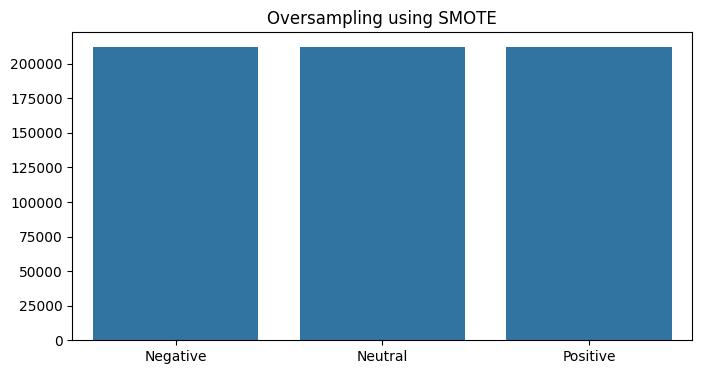

In [39]:
plt.figure(figsize=(8, 4))
idx, c = np.unique(y_train_smote, return_counts=True)
sns.barplot(x=idx, y=c)
plt.title('Oversampling using SMOTE')
plt.show()

In [40]:
print('Original sample: ', np.unique(y_train, return_counts=True))
print('After using SMOTE: ', np.unique(y_train_smote, return_counts=True))

Original sample:  (array(['Negative', 'Neutral', 'Positive'], dtype=object), array([ 96273, 212137,  40966]))
After using SMOTE:  (array(['Negative', 'Neutral', 'Positive'], dtype=object), array([212137, 212137, 212137]))


In [41]:
import plotly.express as px
import pandas as pd

# Assuming counts is a list containing the counts of each category
categories = ['Negative', 'Neutral', 'Positive']
counts = [212244, 212244, 212244]

# Creating a DataFrame from the counts data
counts_df = pd.DataFrame({'Category': categories, 'Counts': counts})

# Create a Pie Chart using Plotly Express
fig = px.pie(counts_df, values='Counts', names='Category',
             labels={'Category': 'Sentiment Category', 'Counts': 'Count'},
             title='Distribution of Sentiment Categories',
             hole=0.3,
             color_discrete_sequence=px.colors.qualitative.Set1)

# Set the background color of the Pie Chart to dark grey
fig.update_layout(paper_bgcolor='darkgrey')

# Show the Plotly Pie Chart
fig.show()


In [42]:
from numpy import percentile
import pandas as pd
pd.set_option("display.max_colwidth", 200)
import string
import nltk # for text manipulation
from nltk.stem.porter import *
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from tqdm import tqdm
#from gensim.models.doc2vec import LabeledSentence
import gensim
from sklearn.linear_model import LogisticRegression
from scipy import stats
from sklearn import metrics
from sklearn.metrics import mean_squared_error,mean_absolute_error, make_scorer,classification_report,confusion_matrix,accuracy_score,roc_auc_score,roc_curve
from sklearn.model_selection import train_test_split,cross_val_score,KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.naive_bayes import BernoulliNB
from sklearn import svm
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

Naive Bayes Classifier for MULTICLASS Classification

In [43]:
from sklearn.naive_bayes import MultinomialNB

naiveByes_clf = MultinomialNB()

naiveByes_clf.fit(X_train_smote,y_train_smote)

NB_prediction = naiveByes_clf.predict(X_test_vectorized)
NB_accuracy = accuracy_score(y_test,NB_prediction)
print("Training accuracy Score    : ",naiveByes_clf.score(X_train_smote,y_train_smote))
print("Test accuracy Score : ",NB_accuracy )
print(classification_report(NB_prediction,y_test))

Training accuracy Score    :  0.7812749936754707
Test accuracy Score :  0.6693914935027764
              precision    recall  f1-score   support

    Negative       0.81      0.64      0.71     30815
     Neutral       0.68      0.77      0.72     47160
    Positive       0.26      0.29      0.28      9370

    accuracy                           0.67     87345
   macro avg       0.59      0.56      0.57     87345
weighted avg       0.68      0.67      0.67     87345



In [44]:
# Define Naive Bayes classifier
naiveByes_clf = MultinomialNB()

# Perform cross-validation
cv_scores = cross_val_score(naiveByes_clf, X_train_smote, y_train_smote, cv=5)  # Use 5-fold cross-validation, you can adjust the number of folds as needed

# Print cross-validation scores
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())

# Now fit model on the entire training set
naiveByes_clf.fit(X_train_smote, y_train_smote)

# Predict on the test set
NB_prediction = naiveByes_clf.predict(X_test_vectorized)

# Calculate accuracy on the test set
NB_accuracy = accuracy_score(y_test, NB_prediction)
print("Training accuracy Score:", naiveByes_clf.score(X_train_smote, y_train_smote))
print("Test accuracy Score:", NB_accuracy)
print(classification_report(NB_prediction, y_test))

Cross-Validation Scores: [0.53939646 0.76028032 0.80337361 0.7966091  0.79810185]
Mean CV Accuracy: 0.7395522707115492
Training accuracy Score: 0.7812749936754707
Test accuracy Score: 0.6693914935027764
              precision    recall  f1-score   support

    Negative       0.81      0.64      0.71     30815
     Neutral       0.68      0.77      0.72     47160
    Positive       0.26      0.29      0.28      9370

    accuracy                           0.67     87345
   macro avg       0.59      0.56      0.57     87345
weighted avg       0.68      0.67      0.67     87345



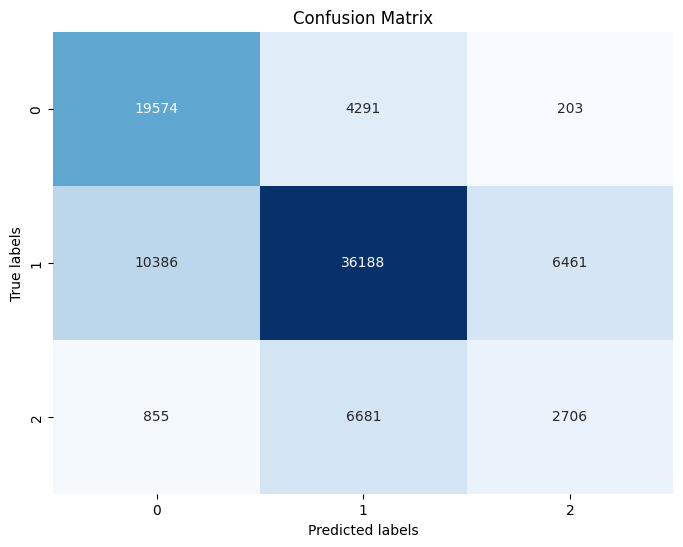

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, NB_prediction)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()


Stochastic Gradient Descent-SGD Classifier( MULTICLASS CLASSIFICATION)

In [45]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(loss = 'hinge', penalty = 'l2', random_state=0)

sgd_clf.fit(X_train_smote,y_train_smote)

sgd_prediction = sgd_clf.predict(X_test_vectorized)
sgd_accuracy = accuracy_score(y_test,sgd_prediction)
print("Training accuracy Score    : ",sgd_clf.score(X_train_smote,y_train_smote))
print("Test accuracy Score : ",sgd_accuracy )
print(classification_report(sgd_prediction,y_test))

Training accuracy Score    :  0.803045516183724
Test accuracy Score :  0.792478104070067
              precision    recall  f1-score   support

    Negative       0.90      0.79      0.84     27461
     Neutral       0.75      0.90      0.82     44066
    Positive       0.77      0.50      0.61     15818

    accuracy                           0.79     87345
   macro avg       0.81      0.73      0.76     87345
weighted avg       0.80      0.79      0.79     87345



In [46]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, classification_report

# Perform cross-validation
cv_predictions = cross_val_predict(sgd_clf, X_train_smote, y_train_smote, cv=5)  # Predictions for each fold

# Compute train accuracy
train_accuracy = accuracy_score(y_train_smote, cv_predictions)
print("Training accuracy Score    : ", train_accuracy)

# Fit the model on the entire training data
sgd_clf.fit(X_train_smote, y_train_smote)

# Predict on the test set
sgd_prediction = sgd_clf.predict(X_test_vectorized)

# Compute test accuracy
test_accuracy = accuracy_score(y_test, sgd_prediction)
print("Test accuracy Score : ", test_accuracy)

# Print classification report for test set
print("Classification Report for Test Set:")
print(classification_report(y_test, sgd_prediction))

# Print classification report for cross-validation predictions
print("Classification Report for Cross-Validation Predictions:")
print(classification_report(y_train_smote, cv_predictions))

Training accuracy Score    :  0.7623485452011357
Test accuracy Score :  0.792478104070067
Classification Report for Test Set:
              precision    recall  f1-score   support

    Negative       0.79      0.90      0.84     24068
     Neutral       0.90      0.75      0.82     53035
    Positive       0.50      0.77      0.61     10242

    accuracy                           0.79     87345
   macro avg       0.73      0.81      0.76     87345
weighted avg       0.82      0.79      0.80     87345

Classification Report for Cross-Validation Predictions:
              precision    recall  f1-score   support

    Negative       0.89      0.82      0.85    212137
     Neutral       0.62      0.76      0.69    212137
    Positive       0.82      0.71      0.76    212137

    accuracy                           0.76    636411
   macro avg       0.78      0.76      0.77    636411
weighted avg       0.78      0.76      0.77    636411



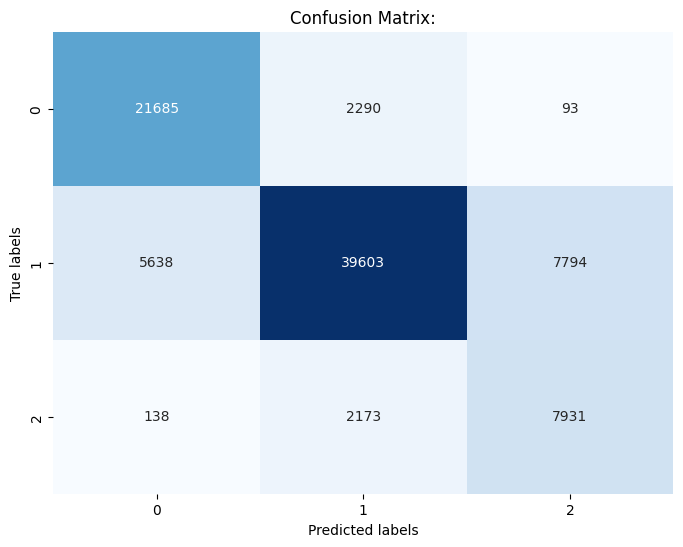

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, sgd_prediction)

# Plot confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix:")
plt.show()


Logistic Regression(For Multiclass Classification)

In [47]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

logreg.fit(X_train_smote, y_train_smote)

logreg_prediction = logreg.predict(X_test_vectorized)
logreg_accuracy = accuracy_score(y_test,logreg_prediction)
print("Training accuracy Score    : ",logreg.score(X_train_smote,y_train_smote))
print("Test accuracy Score : ",logreg_accuracy )
print(classification_report(logreg_prediction,y_test))

Training accuracy Score    :  0.8318775131165238
Test accuracy Score :  0.8337283187360467
              precision    recall  f1-score   support

    Negative       0.93      0.84      0.88     26694
     Neutral       0.79      0.92      0.85     45525
    Positive       0.82      0.55      0.66     15126

    accuracy                           0.83     87345
   macro avg       0.85      0.77      0.80     87345
weighted avg       0.84      0.83      0.83     87345



In [48]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report

# Create the Logistic Regression model
logreg = LogisticRegression()

# Perform cross-validation with 5 folds
cv_scores = cross_val_score(logreg, X_train_smote, y_train_smote, cv=5)

# Print the cross-validation scores
print("Cross-validation Scores:", cv_scores)
print("Mean CV Score:", cv_scores.mean())

# Optionally, fit the model on the entire training data
logreg.fit(X_train_smote, y_train_smote)

# Make predictions on the test set
logreg_prediction = logreg.predict(X_test_vectorized)

# Evaluate the model
logreg_accuracy = accuracy_score(y_test, logreg_prediction)
print("Training accuracy Score    : ", logreg.score(X_train_smote, y_train_smote))
print("Test accuracy Score : ", logreg_accuracy)
print(classification_report(logreg_prediction, y_test))


Cross-validation Scores: [0.6909328  0.83190868 0.8113716  0.79948461 0.79884823]
Mean CV Score: 0.7865091828651289
Training accuracy Score    :  0.8318775131165238
Test accuracy Score :  0.8337283187360467
              precision    recall  f1-score   support

    Negative       0.93      0.84      0.88     26694
     Neutral       0.79      0.92      0.85     45525
    Positive       0.82      0.55      0.66     15126

    accuracy                           0.83     87345
   macro avg       0.85      0.77      0.80     87345
weighted avg       0.84      0.83      0.83     87345



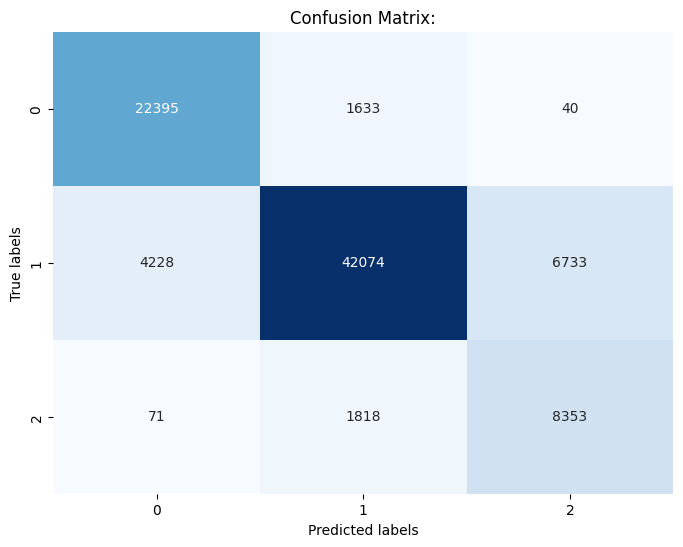

In [56]:
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, logreg_prediction)

# Plot confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix:")
plt.show()


Support Vector Classifier

In [49]:
from sklearn.svm import LinearSVC
svc = LinearSVC()
svc.fit(X_train_smote, y_train_smote)

svc_pred = svc.predict(X_test_vectorized)
svc_accuracy = accuracy_score(svc_pred, y_test)
print("Training accuracy Score    : ",svc.score(X_train_smote,y_train_smote))
print("Test accuracy Score : ",svc_accuracy )
print(classification_report(svc_pred,y_test))

Training accuracy Score    :  0.8391039752612698
Test accuracy Score :  0.7880245005438204
              precision    recall  f1-score   support

    Negative       0.90      0.79      0.84     27319
     Neutral       0.75      0.89      0.81     44488
    Positive       0.74      0.49      0.59     15538

    accuracy                           0.79     87345
   macro avg       0.80      0.72      0.75     87345
weighted avg       0.79      0.79      0.78     87345



In [52]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, accuracy_score
from sklearn.svm import LinearSVC

# Create the SVC model
svc = LinearSVC(C=10, loss='hinge')

# Perform cross-validation with 5 folds
cv_scores = cross_val_score(svc, X_train_smote, y_train_smote, cv=5)

# Print the cross-validation scores
print("Cross-validation Scores:", cv_scores)
print("Mean CV Score:", cv_scores.mean())

# Fit the model on the entire training data
svc.fit(X_train_smote, y_train_smote)

# Make predictions on the test set
svc_prediction = svc.predict(X_test_vectorized)

# Evaluate the model
svc_accuracy = accuracy_score(y_test, svc_prediction)
print("Training accuracy Score: ", svc.score(X_train_smote, y_train_smote))
print("Test accuracy Score: ", svc_accuracy)
print("Classification Report:")
print(classification_report(y_test, svc_prediction))


Cross-validation Scores: [0.61525105 0.79954746 0.79279081 0.78486353 0.78222372]
Mean CV Score: 0.7549353164610004
Training accuracy Score:  0.8369261373546341
Test accuracy Score:  0.7780754479363444
Classification Report:
              precision    recall  f1-score   support

    Negative       0.77      0.88      0.82     24068
     Neutral       0.88      0.74      0.80     53035
    Positive       0.49      0.74      0.59     10242

    accuracy                           0.78     87345
   macro avg       0.72      0.79      0.74     87345
weighted avg       0.80      0.78      0.78     87345



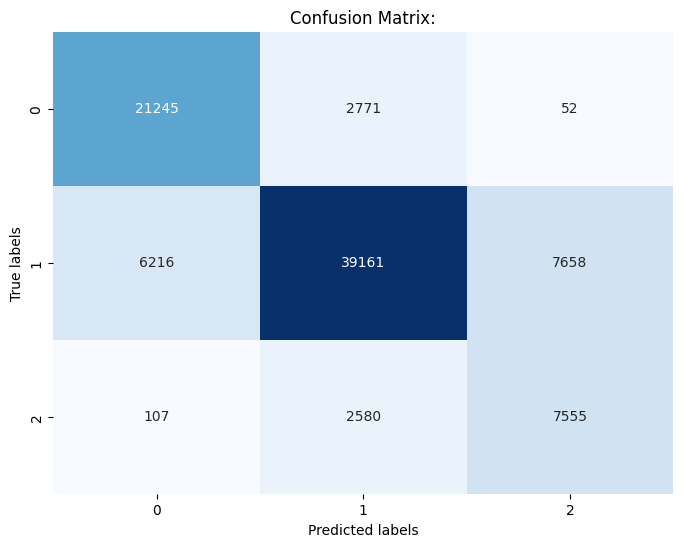

In [57]:
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, svc_prediction)

# Plot confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix:")
plt.show()

All the multiclass models test accuracy in descending order

In [58]:
models = pd.DataFrame({
    'Model': ['Logistic Regression',
              'Naive Bayes',
              'Stochastic Gradient Decent',
              'Support Vector'],
    'Test accuracy': [logreg_accuracy,
              NB_accuracy,
              sgd_accuracy,
              svc_accuracy]})

models.sort_values(by='Test accuracy', ascending=False)

,Model,Test accuracy
0,Logistic Regression,0.833728
2,Stochastic Gradient Decent,0.792478
3,Support Vector,0.778075
1,Naive Bayes,0.669391
